**Analysis owner**: Felipe Matheus <br>
**Date**: 13/04/2021 <br>
**Related JIRA issue**:  https://hurbcom.atlassian.net/browse/ML-90

The objective of this notebook is to develop the linear programming model used to optimze the allocation distribution.
Once the model attendants predictions are given, we need to distribute the inputs in an optimal way following the rules.

This notebook will:
- Validate if linear programming methods perform equally the ad hoc allocation : **YES**
- Validate if all linear programming methods perform equally:                    **YES**
- Validate if the arrangement of hours interfeeres the final cost function:      **YES**
- Validate if the conclusions above remains the same when bounds are considered: **YES**
- Select the one that has inputs more or less distributed:                       **The more distributed is the best and is the `interior-point`**

# Setup

In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
from src.DatasetLoader import DatasetLoader
from src.models.Modeling import Modeling

%load_ext autoreload
%autoreload 2

In [3]:
with open('../configurations/variables.json') as json_file:
    var = json.load(json_file)
BUCKET = var.get('BUCKET')
FOLDER = var.get('FOLDER')
HOURS_NO_ENTER = var.get("HOURS_NO_ENTER")

load = DatasetLoader()
modeling = Modeling()

# Loading DF from feature engineering

In [4]:
df = load.load_df_pickle(BUCKET, f'{FOLDER}df_preds.pkl')
df.columns = ['prediction', 'chats', 'prediction_round']

In [5]:
df

,prediction,chats,prediction_round
time,,,
2021-03-22 00:00:00,35.198842,180.494989,35.0
2021-03-22 01:00:00,19.686423,101.293788,20.0
2021-03-22 02:00:00,10.759026,55.411962,11.0
2021-03-22 03:00:00,7.243151,33.319375,7.0
2021-03-22 04:00:00,6.433121,28.229416,6.0
...,...,...,...
2021-03-28 19:00:00,97.099409,469.034280,97.0
2021-03-28 20:00:00,101.007650,508.743177,101.0
2021-03-28 21:00:00,97.971657,477.517544,98.0


In [6]:
sum(df.chats)

90000.00000000004

# Testing different inputs' ways

## 1. AD hoc allocation.
Deterministic way, consisting on allocating starting at 4am (hour with least values) the necessary number of attendants.
Always inputting the actual need of attendants

### DataFrame visualization. 

**OBS** : _attendants input_ is the amount of attendants entering that hour.

In [6]:
df_final = modeling.get_attendant_distribution(df)
df_final.head(15)

,prediction,chats,prediction_round,attendants_online,attendants_input,attendants_output
time,,,,,,
2021-03-22 00:00:00,35.198842,180.494989,35.0,NaN,NaN,NaN
2021-03-22 01:00:00,19.686423,101.293788,20.0,NaN,NaN,NaN
2021-03-22 02:00:00,10.759026,55.411962,11.0,NaN,NaN,NaN
2021-03-22 03:00:00,7.243151,33.319375,7.0,NaN,NaN,NaN
2021-03-22 04:00:00,6.433121,28.229416,6.0,6.0,6.0,0.0
2021-03-22 05:00:00,8.202548,39.347908,8.0,8.0,2.0,0.0
2021-03-22 06:00:00,19.496718,100.319115,19.0,19.0,11.0,0.0
2021-03-22 07:00:00,62.672620,261.501141,63.0,63.0,44.0,0.0
2021-03-22 08:00:00,105.933792,611.192133,106.0,106.0,43.0,0.0


### Sum of inputs - objective function value.
The objective function (the value we want to reduce most) will be the sum of inputs, with less people we answer the demands the better it is.

**OBS**: this firts case does not consider the first 4 hours.

In [7]:
sum(df_final.dropna().attendants_input)

2374.0

## Testing linear programming methods.
## 2. Simplex with 168 hours, starting at midnight.
The objective function is represented by _fun_

In [8]:
modeling.get_attendant_distribution_simplex(df)

     con: array([], dtype=float64)
     fun: 2409.0
 message: 'Optimization terminated successfully.'
     nit: 181
   slack: array([ 0., 15., 24., 28., 41., 56., 49., 37.,  6.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  2., 13., 32., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        3., 16., 30., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,
       35., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14., 26., 51., 21.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 25., 41., 31.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., 13.,  9.,  0.,  0.,  0.,  0.,  0.,
        0.

## 3. Simplex with same AD hoc allocation conditions.
To verify if _fun_ (cost function) matches the same as summing AD Hoc's _attendants_  _input_ . We started considering at 4 am.

In [9]:
modeling.get_attendant_distribution_simplex(df.tail(164))

     con: array([], dtype=float64)
     fun: 2374.0
 message: 'Optimization terminated successfully.'
     nit: 183
   slack: array([ 6., 21., 49., 37.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 13.,
       32., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 16., 30., 12.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14., 35., 12.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., 14., 26., 51., 21.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  7., 25., 41., 31.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., 13.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.

## Conclusion: 
Same cost function but arrengement is different. So, linear programming meets the AD Hoc baseline. Therefore, we will use it as the method to optimze the inputs.

## 4. Simplex with 168 hours but starting at 4 am.
### Illustrating reshifted DataFrame.

In [10]:
pd.concat([df.tail(164), df.head(4)])

,prediction,chats,prediction_round
time,,,
2021-03-22 04:00:00,6.433121,28.229416,6.0
2021-03-22 05:00:00,8.202548,39.347908,8.0
2021-03-22 06:00:00,19.496718,100.319115,19.0
2021-03-22 07:00:00,62.672620,261.501141,63.0
2021-03-22 08:00:00,105.933792,611.192133,106.0
...,...,...,...
2021-03-28 23:00:00,68.771839,281.355590,69.0
2021-03-22 00:00:00,35.198842,180.494989,35.0
2021-03-22 01:00:00,19.686423,101.293788,20.0


### Result:

In [11]:
modeling.get_attendant_distribution_simplex(pd.concat([df.tail(164), df.head(4)]))

     con: array([], dtype=float64)
     fun: 2378.0
 message: 'Optimization terminated successfully.'
     nit: 185
   slack: array([ 6., 21., 49., 37.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 13.,
       32., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 16., 30., 12.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14., 35., 12.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., 14., 26., 51., 21.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  5., 25., 41., 31.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2., 13., 42., 42., 22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.

## Conclusion:
When reshifting the order we obtain a better cost function. So, if we start allocations at 4 a.m. we can obtain better values.

# Testing best linprog method
Getting all linprog methods

In [12]:
methods_res = modeling.get_fun_linprog_methods(df)

## Analyzing methods' cost function

In [15]:
for method in methods_res:
    print(method, " : ", methods_res[method]['fun'])

highs-ds  :  2409.0
highs-ipm  :  2409.0
highs  :  2409.0
interior-point  :  2409.0
revised simplex  :  2409.0
simplex  :  2409.0


## Conclusion
All methods optimize equally, the difference will be at the arrangement.

# Analyzing methods' arrangement

In [14]:
pd.DataFrame(
    {method: np.array(methods_res[method]['x']) for method in methods_res},
    index=df.index, columns = [method for method in methods_res]
).head(24)

,highs-ds,highs-ipm,highs,interior-point,revised simplex,simplex
time,,,,,,
2021-03-22 00:00:00,35.0,35.0,35.0,35.0,35.0,35.0
2021-03-22 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 04:00:00,0.0,0.0,0.0,1.0,12.0,0.0
2021-03-22 05:00:00,19.0,23.0,19.0,5.0,17.0,0.0
2021-03-22 06:00:00,0.0,0.0,0.0,23.0,39.0,68.0
2021-03-22 07:00:00,44.0,40.0,44.0,38.0,32.0,32.0
2021-03-22 08:00:00,43.0,43.0,43.0,39.0,12.0,12.0


## Conclusion:
   - As more conditions and bounds are going to be set by stakeholders and optimzation algorithms hit a similar cost function than AD Hoc allocation, there's no reason to continue with AD Hoc allocation.
   - Different methods proved to arrange in different ways. When more conditions are applied a new assessment need to be done to evalueate cost functions.
   - It was already said by stakeholders that starting at 4a.m. will not be possible due to restrictions. However, a good insight was obtained once we noticed that lost function can be decreased if we start by the hour with less amount of attendants.

# Application of bounds

In [25]:
methods_res_bounds = modeling.get_fun_linprog_methods(df, hours_no_enter=HOURS_NO_ENTER)
for method in methods_res_bounds:
    print(method, " : ", methods_res_bounds[method]['fun'])

highs-ds  :  2495.0
highs-ipm  :  2495.0
highs  :  2495.0
interior-point  :  2495.0
revised simplex  :  2495.0
simplex  :  2495.0


## Conclusion
Even with bounds all methods perform the same.

# Analyzing methods' arrangement with bounds.
To see which one is more distributed and ask for the stakeholders which one is the best. Considering already the prod case, the closer to the reality.
We will do the following assessments:
- Visualization of first 2 days.
- Analyze how many null inputs each method has.
- Histogram.
- Quantile assessments.

In [ ]:
df_models = pd.DataFrame(
    {method: np.array(methods_res_bounds[method]['x']) for method in methods_res_bounds},
    index=df.index, columns = [method for method in methods_res_bounds]
)

## Visual 1st and 2nd day analysis

In [54]:
df_models.head(24)

,highs-ds,highs-ipm,highs,interior-point,revised simplex,simplex
time,,,,,,
2021-03-22 00:00:00,35.0,35.0,35.0,35.0,35.0,35.0
2021-03-22 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-22 06:00:00,63.0,19.0,63.0,30.0,70.0,70.0
2021-03-22 07:00:00,0.0,44.0,0.0,34.0,0.0,0.0
2021-03-22 08:00:00,43.0,43.0,43.0,45.0,48.0,48.0


In [53]:
df_models.iloc[24:48].head(24)

,highs-ds,highs-ipm,highs,interior-point,revised simplex,simplex
time,,,,,,
2021-03-23 00:00:00,14.0,14.0,14.0,14.0,14.0,14.0
2021-03-23 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-23 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-23 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-23 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-23 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-23 06:00:00,29.0,29.0,29.0,41.0,84.0,84.0
2021-03-23 07:00:00,55.0,55.0,55.0,43.0,0.0,0.0
2021-03-23 08:00:00,26.0,26.0,26.0,32.0,53.0,53.0


## Analyzing the non null values
We analyse which one has more "gaps" considering the amount of zeros.

In [56]:
(df_models == 0.0).sum(axis=0)

highs-ds           89
highs-ipm          77
highs              89
interior-point     70
revised simplex    84
simplex            84
dtype: int64

## Histogram

array([[<AxesSubplot:title={'center':'highs-ds'}>,
        <AxesSubplot:title={'center':'highs-ipm'}>],
       [<AxesSubplot:title={'center':'highs'}>,
        <AxesSubplot:title={'center':'interior-point'}>],
       [<AxesSubplot:title={'center':'revised simplex'}>,
        <AxesSubplot:title={'center':'simplex'}>]], dtype=object)

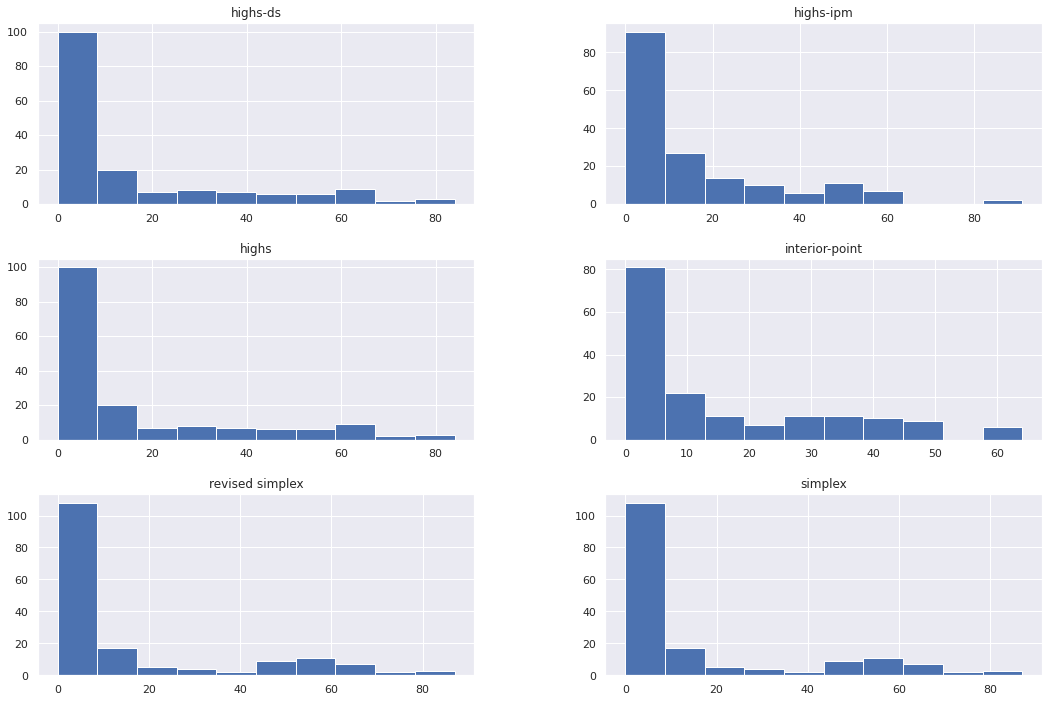

In [40]:
df_models.hist(figsize=(18,12))

## Percentile Analysis
We want the lowest percentiles possible.

In [50]:
pd.DataFrame(
    [df_models.quantile(i/10).values for i in range(10)],
    index=range(10), columns = df_models.columns
)

,highs-ds,highs-ipm,highs,interior-point,revised simplex,simplex
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,5.5,0.0,7.0,0.5,0.5
6,9.0,13.0,9.0,12.0,6.0,6.0
7,14.9,17.9,14.9,23.0,12.9,12.9
8,31.8,29.0,31.8,32.0,32.2,32.2
9,54.0,49.9,54.0,43.0,55.3,55.3


# Final Conclusion:
All methods were equally good when considering the ociosity reduction, however some of them distribute better, while others as simplex like algorithms focus on the allocation inside one hour.

This question was taken to the stakeholders, then, once all algorithms work on the same way, it's up to them to choose which one suits them better.

The difference between algorithm working with restrictions to working without them was 2495 - 2409 = 86 more entries during the whole week. Considerng this last week of May.

When considering the 2nd and 3rd week of June, we got a difference of 2533/2569 ~ 1% of difference when applying restrictions or dont, so the algorithm adapt itself during the weeks.

---------------------------------------------------------------------------

After ther Stakeholder's feedback, the most distributed the better, and the most distributed algorithm is the `interior-point`, as we can see on the assessments above.